In [18]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
import PyQt5
import skimage.morphology as morph
import skimage
from scipy import ndimage

# Preprocessing frame rate

In [19]:

# Time resolution for the different videos: 
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
minTimeResolution = min(timeResolution)
n_frames = np.array([14516, 4372, 4625, 4078, 3983, 4943, 4593])

# Method to retreive the temporal downsambled videos 
def downsampleTimeResolution(timeResolution,minTimeResolution,n_frames,flag):
    indices = np.round(np.linspace(0,timeResolution-1,minTimeResolution)).astype(int)
    downsample = np.zeros([timeResolution])
    downsample[indices] = 1
    if flag==1:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution))) # returns boolean array
        print(downsampleFrames.shape)
        return downsampleFrames
    
    else:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution)))
        downsampleFramesIdx = np.where(downsampleFrames==1) # return indices of frames to sample in video
        print(downsampleFramesIdx[0].shape)
        return downsampleFramesIdx

In [20]:
videosList=[]
max_frames = 300

# Load and save all videos to numpy object
for vidIdx in range(2):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    n_frames = int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT))
    sampleFrames = downsampleTimeResolution(timeResolution[vidIdx],minTimeResolution,n_frames,1)
    print(sampleFrames.shape)
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened() and frameIdx<sampleFrames.shape[0]) and frameIdx<100:
        ret, frame = vidCv2.read()
        if ret == True and sampleFrames[frameIdx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))

    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()


(14500,)
(14500,)
volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

(4368,)
(4368,)
volunteer02.mp4:

number of frames: 4372
frame size: 712 x 480 



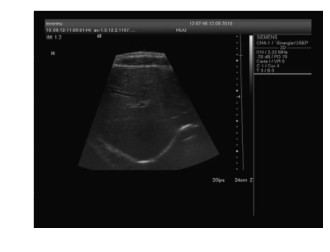

In [33]:
# Run example of video

videoIdx = 0 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

if noFrames > videosList[videoIdx].shape[0]:
    noFrames = videosList[videoIdx].shape[0]

vidShow=videosList[videoIdx][:noFrames]
for frame in range(noFrames):
    plt.imshow(vidShow[frame],cmap='gray')
    plt.show()
    clear_output(wait=True)

In [ ]:
# Switch to interactive mode
#%matplotlib qt 

# ptsList=[]
# for vidIdx in range(len(videosList)):
#     plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
#     pts=plt.ginput(4)
#     ptsList.append(np.array(pts))
#     plt.show()
#     plt.close()
# ptsArray = np.array(ptsList).astype(np.float32)
# np.savez('transPts',ptsArray)

# Switch back to inline mode
#%matplotlib inline 

In [34]:
# Load the points used for afine tranformation -- Found with commented code above 
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [40]:
# Transfor all videos have the same field of view as the agreed upon reference video
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

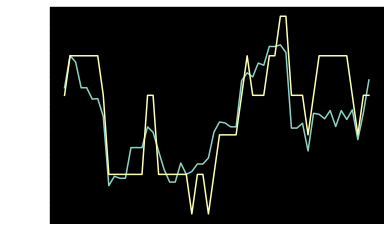

In [41]:
Time = [x for x in range(0,14*60)]
from scipy import ndimage

# gaussian filter: 
tmp = videosTransList[0]/255
blurred = ndimage.gaussian_filter(tmp[:,:,:],sigma=(0,2,2))

plt.figure()
plt.plot(blurred[:,200,200])
plt.plot(tmp[:,200,200])

### Mask videos with binary morphology

In [47]:
# Creating mask for field of view and removing background
disk = np.zeros((40,40))
element = skimage.draw.disk((20,20),9,shape=(40,40))
sigma_for_gaussian_filter = (3,3)
disk[element]=1
morphsInput = []
videoMasks = []
videosTransMaskList = []

for vidIdx,frame in enumerate(videosTransList):
    vidThr = np.zeros(frame.shape[1:])
    for frameIdx,frame in enumerate(frame):
        vidThr+=frame>10
    morphInput=vidThr>0
    vidMask = morph.opening(morphInput,disk) # First opening
    vidMask = morph.closing(vidMask,disk) # Then closing
    morphsInput.append(morphInput)
    videoMasks.append(vidMask)
    tmp_blurred = ndimage.gaussian_filter(frame,sigma=sigma_for_gaussian_filter)
    videosTransMaskList.append(tmp_blurred*vidMask[None,:,:])

Text(0.5, 1.0, 'Final processed video')

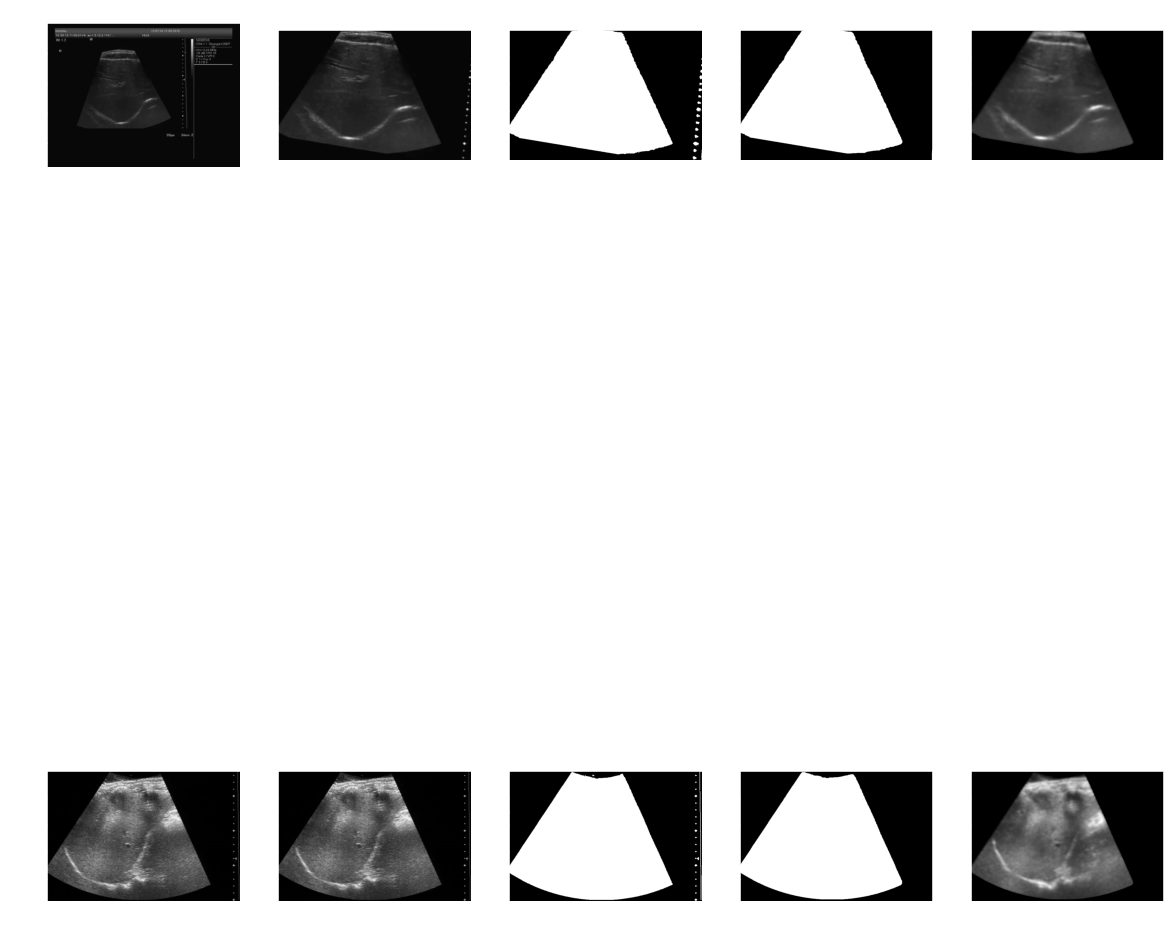

In [48]:
# Visualisation of final frames of final videos: 
fig,ax = plt.subplots(len(videosList),5,figsize=(20,25))
for vidIdx in range(len(videosList)):
        ax[vidIdx,0].imshow(videosList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videosTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(videoMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videosTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


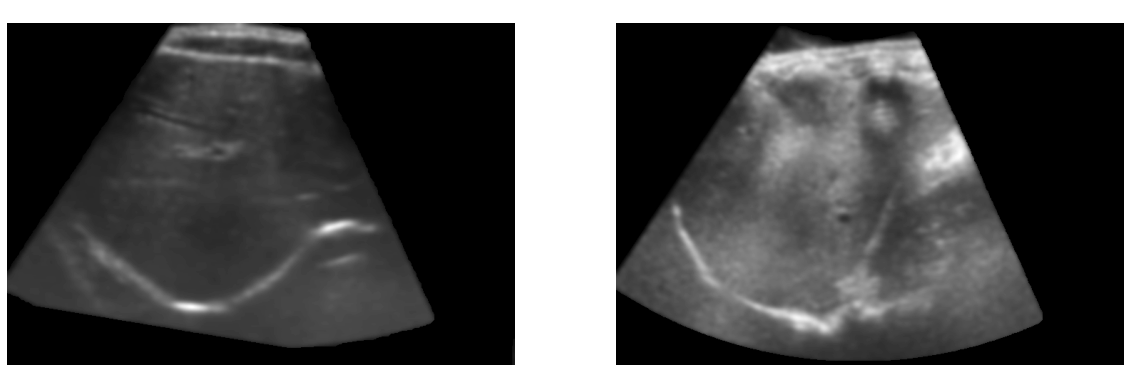

In [51]:
# Plot the first frame of each video in videosList in subplots
fig, axs = plt.subplots(1, len(videosTransMaskList), figsize=(20, 20))
for i in range(len(videosTransMaskList)):
    axs[i].imshow(videosTransMaskList[i][0], cmap='gray')
    axs[i].set_title(f'Video {i+1}')
    axs[i].axis('off')
plt.show()


    

# Setup model

In [83]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random
import time
from numpyro.infer import MCMC, NUTS

In [84]:
# Carry function
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = jnp.matmul(beta,z_prev) 
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [88]:

def model(T, T_forecast, output_dim, obs=None):

    latent_dim = 2

    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """

    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros((latent_dim,latent_dim)), scale=jnp.ones((latent_dim,latent_dim))))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(latent_dim)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.5))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(latent_dim), scale=jnp.ones(latent_dim)))
    h_matrix = numpyro.sample(name="h_matrix", fn=dist.Normal(loc=jnp.ones((output_dim,latent_dim)),scale=jnp.ones((output_dim,latent_dim))))
    
    """
    Define LKJ prior
    """

    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(latent_dim, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(latent_dim), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """

    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = jax.lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """

    numpyro.sample(name="y_pred", fn=dist.MultinomialNormal(loc=(jnp.matmul(h_matrix,z_collection[T:].T)).T, scale = sigma), obs=None) 
    numpyro.sample(name="y_obs", fn=dist.MultinomialNormal(loc=(jnp.matmul(h_matrix,z_collection[:T].T)).T, scale = sigma), obs=obs)
 

    return z_collection

In [86]:
temp = np.array(videosList[0][0:10,200:205,200:205])
temp = temp / temp.mean(axis=(0,1))
temp = temp.reshape(temp.shape[0],-1)


In [89]:
N = 144
test_x = np.linspace(0,10,N)
test_y = np.sin(test_x) + np.random.normal(0,0.1,N)
test_y2D = np.tile(test_y,(4,1)).T
test_y2D.shape

t0 = time.time()


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
#mcmc.run(rng_key_, T=N, T_forecast=0, obs1=y_obs1, ix_mis1=ix_mis1, ix_obs1=ix_obs1, 
#         obs2=y_obs2, ix_mis2=ix_mis2, ix_obs2=ix_obs2)
mcmc.run(rng_key_, T=N, T_forecast=100, output_dim=test_y2D.shape[1], obs=test_y2D)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

AttributeError: module 'numpyro.distributions' has no attribute 'MultinomialNormal'

In [72]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
 L_Omega[1,0]     -0.11      0.00     -0.11     -0.11     -0.11      0.50      1.00
 L_Omega[1,1]      0.99      0.00      0.99      0.99      0.99      0.50      1.00
    beta[0,0]     -0.13      0.00     -0.13     -0.13     -0.13      0.50      1.00
    beta[0,1]      0.84      0.00      0.84      0.84      0.84      0.50      1.00
    beta[1,0]     -0.25      0.00     -0.25     -0.25     -0.25      0.50      1.00
    beta[1,1]      0.83      0.00      0.83      0.83      0.83      0.50      1.00
h_matrix[0,0]     -0.11      0.00     -0.11     -0.11     -0.11      0.50      1.00
h_matrix[0,1]     -0.06      0.00     -0.06     -0.06     -0.06      0.50      1.00
h_matrix[1,0]     -0.00      0.00     -0.00     -0.00     -0.00      0.50  

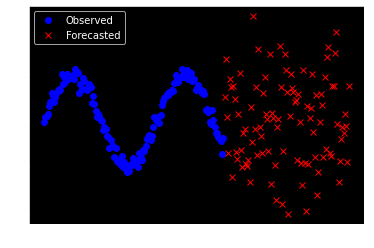

In [73]:
samples = {k:v for k, v in mcmc.get_samples().items()}
samples['y_pred'].shape

# get mean and standard devitions for predictions
y_mean = samples["y_pred"][:,:,2].mean(axis=0)
y_std = samples["y_pred"][:,:,2].std(axis=0)

y_pred_025 = y_mean - 1.96*y_std
y_pred_975 = y_mean + 1.96*y_std

plt.plot(range(N),test_y,"bo")
plt.plot(range(N,N+100),y_mean,"rx")
plt.fill_between(range(N,N+100), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["Observed","Forecasted"])
plt.show()


In [47]:
t0 = time.time()


rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=10, num_chains=1)
#mcmc.run(rng_key_, T=N, T_forecast=0, obs1=y_obs1, ix_mis1=ix_mis1, ix_obs1=ix_obs1, 
#         obs2=y_obs2, ix_mis2=ix_mis2, ix_obs2=ix_obs2)
mcmc.run(rng_key_, T=temp.shape[0], T_forecast=20, output_dim=temp.shape[1], obs=temp)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 1010/1010 [00:20<00:00, 50.46it/s, 14 steps of size 3.40e-03. acc. prob=0.17] 


Total time: 0.358m


In [43]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       H[0,0]      0.51      0.05      0.51      0.45      0.56     26.62      1.14
       H[0,1]     -1.77      0.08     -1.78     -1.84     -1.66     13.16      1.20
       H[1,0]      1.70      0.11      1.69      1.61      1.77     32.06      1.01
       H[1,1]     -1.18      0.04     -1.17     -1.24     -1.11     22.61      1.00
       H[2,0]      3.23      0.10      3.26      3.12      3.35      5.99      1.51
       H[2,1]     -0.55      0.10     -0.56     -0.63     -0.46      7.24      1.20
       H[3,0]     -1.71      0.21     -1.84     -1.89     -1.38      3.22      1.75
       H[3,1]     -2.67      0.11     -2.72     -2.81     -2.51      3.25      1.93
       H[4,0]     -0.82      0.10     -0.81     -0.91     -0.71     21.30      1.00
       H[4,1]     -2.04      0.09     -2.03     -2.13     -1.94     23.70      1.04
       H[5,0]      1.02      0.11      1.00      0.95      1.17     16.12  

In [29]:
samples = {k:v for k, v in mcmc.get_samples().items()}
samples['y_pred'].shape


(1000, 20, 25)

In [37]:
temp = samples['y_pred']
print(temp.shape)
base = np.array(videosList[0][0:20,200:205,200:205])
temp_mean = temp[:,0,:].mean(axis=0)
print(temp_mean.shape)

(1000, 20, 25)
(25,)


In [39]:
print(base[11,:]/base[11,:].mean(axis=0))
print(temp_mean[:])

[[0.86294416 0.81081081 0.74       0.71705426 0.73929961]
 [0.86294416 0.81081081 0.82       0.83333333 0.85603113]
 [0.98984772 0.96846847 0.98       1.00775194 0.9922179 ]
 [1.1928934  1.26126126 1.28       1.24031008 1.16731518]
 [1.09137056 1.14864865 1.18       1.20155039 1.24513619]]
[ 0.26508275  0.90277344  0.37157148  0.32389337  0.9821998  -0.01650346
  1.4473538  -0.01119505 -0.38650233  0.61418736  0.8923012   0.60355854
  1.2360945   0.72306824  0.7753851   0.9804856   0.55045855  0.26524183
  0.4721023   0.6165911   0.690042    0.4218782   0.76947314  1.4025701
  0.9114891 ]


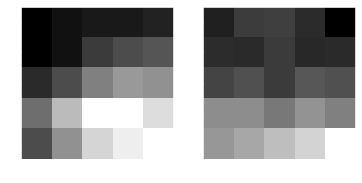

In [20]:
%matplotlib inline
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(base[11,:].reshape(5,5),cmap='gray')
ax2.imshow(temp_mean.reshape(5,5),cmap='gray') 
plt.show()

In [81]:
samples.keys()

dict_keys(['H', 'L_Omega', 'beta', 'noises', 'sigma', 'tau', 'y_pred', 'z_1'])

(1000, 25, 2) H


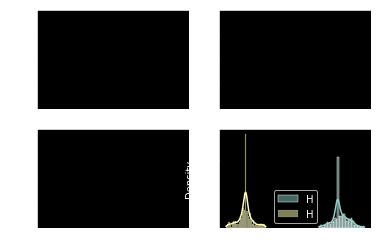

(1000, 2) tau


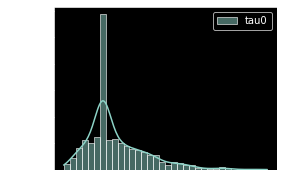

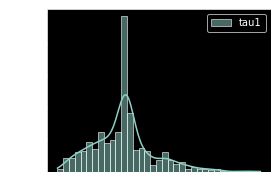

(1000, 2, 2) beta


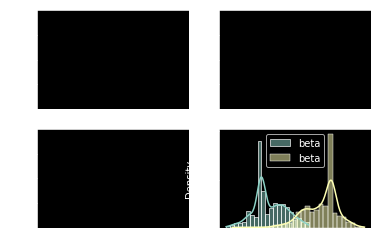

In [21]:
import seaborn as sns
nodes = ["H", "tau","beta"]
for node in nodes:
  if node in ("tau"):
    print(samples[node].shape,node)
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.histplot(samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()
  else:
    print(samples[node].shape,node)
    fig, axs = plt.subplots(2,2)
    for i in range(2):
      axs[i] = sns.histplot(samples[node][:,i,i], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()